In [67]:
import numpy as np
import pandas as pd
import cv2
import skfuzzy as fuzz
import skfuzzy.control as ctrl
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.layers import Dense, Flatten, Dropout, GlobalAveragePooling2D
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import os

In [50]:
#loading the dataset path
dataset_path = "C:\\Users\\Stiena\\Documents\\VIT\\Alzheimer's disease\\Alzheimer's disease\\Capstone-Alzheimer's-present\\Data"
if os.path.exists(dataset_path):
    print("✅ Dataset directory found!")
else:
    print("❌ Dataset directory NOT found. Check the path.")

✅ Dataset directory found!


In [55]:
#Load dataset with Train-Validation Split
img_size = (128, 128)
batch_size = 32

dataset_train = image_dataset_from_directory(
    dataset_path,
    image_size=img_size,
    batch_size=batch_size,
    label_mode="int",  # Integer labels
    validation_split=0.2,
    subset="training",
    seed=42,
    shuffle=True
)

dataset_val = image_dataset_from_directory(
    dataset_path,
    image_size=img_size,
    batch_size=batch_size,
    label_mode="int",  # Integer labels
    validation_split=0.2,
    subset="validation",
    seed=42,
    shuffle=True
)

Found 86437 files belonging to 4 classes.
Using 69150 files for training.
Found 86437 files belonging to 4 classes.
Using 17287 files for validation.


In [56]:
#Get class names
class_names = dataset_train.class_names
num_classes = len(class_names)
print(f"Classes: {class_names}")

Classes: ['Mild Dementia', 'Moderate Dementia', 'Non Demented', 'Very mild Dementia']


In [58]:
#Data Preprocessing: Augmentation & Normalization
preprocessing_layer = tf.keras.Sequential([
    RandomFlip("horizontal"),
    RandomRotation(0.2),
    Rescaling(1./255)  # Normalize pixel values
])
#Apply preprocessing while loading dataset
dataset_train = dataset_train.map(lambda x, y: (preprocessing_layer(x), y))
dataset_val = dataset_val.map(lambda x, y: (Rescaling(1./255)(x), y))

In [59]:
#Load Pretrained CNN Model (MobileNetV2)
base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=(128, 128, 3))

#Unfreeze last 20 layers for better learning
for layer in base_model.layers[-20:]:
    layer.trainable = True

x = base_model.output
x = GlobalAveragePooling2D()(x)  # Pooling layer
x = Dense(128, activation='relu')(x)  # Fully connected layer
x = Dense(64, activation='relu')(x)
predictions = Dense(num_classes, activation='softmax')(x)  # Output layer

In [60]:
#Define Model
model = Model(inputs=base_model.input, outputs=predictions)

#Compile Model with a lower learning rate
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

In [61]:
#Train Model (Now storing history)
epochs = 15  # Increased epochs for better learning
history = model.fit(dataset_train, validation_data=dataset_val, epochs=epochs)

Epoch 1/15
2161/2161 ━━━━━━━━━━━━━━━━━━━━ 555s 247ms/step - accuracy: 0.7941 - loss: 0.4993 - val_accuracy: 0.1610 - val_loss: 1.7048
Epoch 2/15
2161/2161 ━━━━━━━━━━━━━━━━━━━━ 528s 244ms/step - accuracy: 0.8897 - loss: 0.2678 - val_accuracy: 0.5962 - val_loss: 1.4213
Epoch 3/15
2161/2161 ━━━━━━━━━━━━━━━━━━━━ 537s 248ms/step - accuracy: 0.9462 - loss: 0.1419 - val_accuracy: 0.7826 - val_loss: 1.4243
Epoch 4/15
2161/2161 ━━━━━━━━━━━━━━━━━━━━ 532s 246ms/step - accuracy: 0.9690 - loss: 0.0853 - val_accuracy: 0.8229 - val_loss: 0.7635
Epoch 5/15
2161/2161 ━━━━━━━━━━━━━━━━━━━━ 534s 247ms/step - accuracy: 0.9788 - loss: 0.0577 - val_accuracy: 0.8075 - val_loss: 1.0005
Epoch 6/15
2161/2161 ━━━━━━━━━━━━━━━━━━━━ 534s 247ms/step - accuracy: 0.9841 - loss: 0.0444 - val_accuracy: 0.8367 - val_loss: 0.5813
Epoch 7/15
2161/2161 ━━━━━━━━━━━━━━━━━━━━ 534s 247ms/step - accuracy: 0.9876 - loss: 0.0361 - val_accuracy: 0.8512 - val_loss: 0.5664
Epoch 8/15
2161/2161 ━━━━━━━━━━━━━━━━━━━━ 533s 246ms/step - ac

In [62]:
#Function to Plot Accuracy & Loss Curves
def plot_accuracy_loss(history):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    epochs_range = range(len(acc))
    
    plt.figure(figsize=(12, 5))
    
    # Accuracy Curve
    plt.subplot(1, 2, 1)
    plt.plot(epochs_range, acc, label='Training Accuracy', marker='o')
    plt.plot(epochs_range, val_acc, label='Validation Accuracy', marker='s')
    plt.xlabel("Epochs")
    plt.ylabel("Accuracy")
    plt.title("Training & Validation Accuracy Curve")
    plt.legend()
    
    # Loss Curve
    plt.subplot(1, 2, 2)
    plt.plot(epochs_range, loss, label='Training Loss', marker='o', linestyle="--")
    plt.plot(epochs_range, val_loss, label='Validation Loss', marker='s', linestyle="--")
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.title("Training & Validation Loss Curve")
    plt.legend()
    
    plt.show()


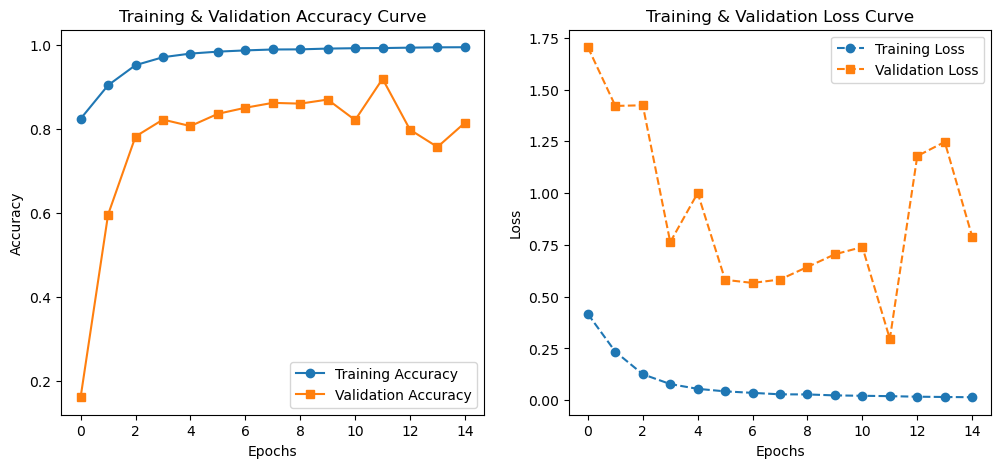

In [63]:
#Call the function to plot accuracy & loss curves
plot_accuracy_loss(history)

In [64]:
#Evaluate Model
y_true = np.concatenate([y for _, y in dataset_val.as_numpy_iterator()])  # Get true labels
y_pred_probs = model.predict(dataset_val)  # Get predictions
y_pred = np.argmax(y_pred_probs, axis=1)  # Convert to class labels

541/541 ━━━━━━━━━━━━━━━━━━━━ 28s 51ms/step


In [65]:
#Compute Evaluation Metrics (Fixing `zero_division` warning)
print("Classification Report:")
print(classification_report(y_true, y_pred, target_names=class_names, zero_division=1))

541/541 ━━━━━━━━━━━━━━━━━━━━ 26s 48ms/step
Classification Report:
                    precision    recall  f1-score   support

     Mild Dementia       0.06      0.12      0.08      1038
 Moderate Dementia       0.00      0.00      1.00       106
      Non Demented       0.77      0.67      0.72     13360
Very mild Dementia       0.15      0.19      0.17      2783

          accuracy                           0.56     17287
         macro avg       0.25      0.25      0.49     17287
      weighted avg       0.63      0.56      0.59     17287



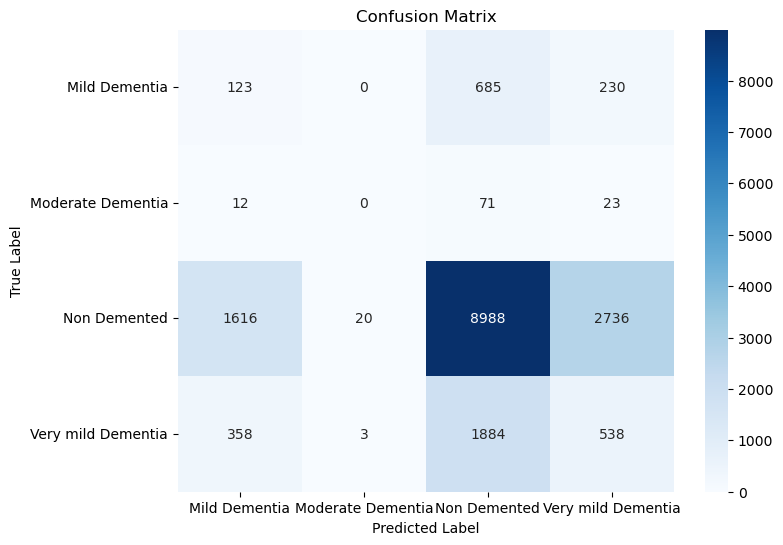

In [66]:
#Confusion Matrix
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=class_names, yticklabels=class_names)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()
